# EXP3. 카메라 스티커 앱 만들기

### 목표
주어진 이미지에서 얼굴을 인식하고 적절한 위치에 수염 스티커 적절하게 붙이기

### 1. 이미지 가져오기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

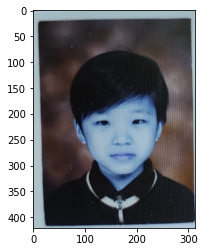

(421, 313, 3)


In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)
img_show = img_bgr.copy() # 원본은 따로 저장
plt.imshow(img_bgr)
plt.show()
print(img_bgr.shape)

opencv로 이미지를 가져올 때 이미지 채널을   
RGB가 아닌 BGR로 가져와서 퍼렇게 나온다.

cv2.COLOR_BGR2RGB로 채널을 바꿔서 가져오자.   
관련 [opencv 홈페이지](https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html)

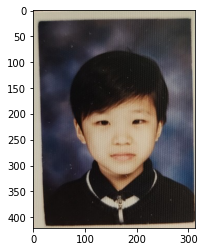

(421, 313, 3)


In [3]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()
print(img_rgb.shape)

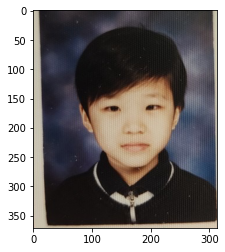

In [4]:
slice_test = img_rgb.copy()


plt.imshow(slice_test[50:])
plt.show()
# plt.imshow(slice_test[:50])
# plt.show()

### 2-1. 얼굴 검출 face detection

앞으로 사용하게 될 dlib의 face detector는 HOG와 SVM을 이용한다.   
HOG(Histogram of Oriented Gradients)는 이미지 색상의 변화량에서 찾는 것이고,   SVM(Support Vector Machine)은 선형 분류기이다.  

HOG를 이용해 이미지를 벡터로 만들고 SVM은 여러 벡터를 구분지으며   
얼굴의 위치를 sliding window로 찾는다.

In [5]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rgb, 1)

출력값의 두 번째 파라미터는 이미지를 upsampling하는 이미지 피라미드의 수이다.   
이를 하는 이유는 detect된 얼굴을 크게 봐서 정확한 검출이 가능하기 때문이다.   
[더보기](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

rectangles[[(110, 182) (239, 311)]]


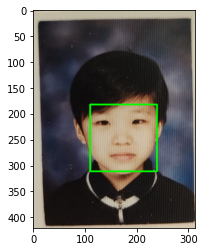

In [6]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 2-2 얼굴 랜드마크 face landmark

스티커를 섬세하게 붙이려면 이목구비를 알아야 한다.   
이를 face landmark localization 기술이라고 한다.   
위에 작업한 detection의 결과물인 bounding box를 이용한다.   

face landmark처럼 객체 내부의 점을 찾는 기술을   
object keypoint estimation이라 한다.
이 keypoint를 찾는 알고리즘은 크게 둘로 나뉘는데,   
1. top-down: bounding box를 찾고 내부에서 keypoint 예측
2. bottom-up: 전체의 keypoint 찾고 point 관계를 군집화 해서 box 만들기

1번을 사용해서 이목구비를 찾을것이다.   
ibug 300w 데이터셋은 68개의 keypoint 사용한다.   
[AFLW dataset](https://www.tugraz.at/institute/icg/research/team-bischof/lrs/downloads/aflw/)

이번에 활용한 데이터셋은
`wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2`   
을 통해 다운받을 수 있다. bz2 압축파일을 풀어준 뒤 사용하자.

In [7]:
model_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [8]:
list_landmarks = []

# 얼굴 박스마다 face landmark 좌표 알아내기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


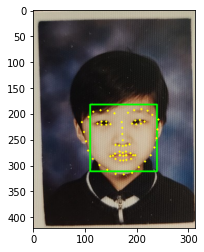

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3. 스티커 적용하기

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/E-8-8.png)   
랜드마크의 포인트별 번호 참고해서 적용하기

### 3-1. 스티커 사이즈 조정해서 불러오기

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[33])
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

print(landmark[33])

(173, 262)
(x,y) : (173,262)
(w,h) : (130,130)
(173, 262)


(130, 130, 3)


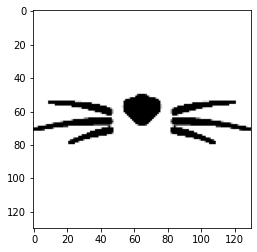

In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지 불러오기
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.scatter(x, y, marker='o')
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)) # 스티커 확인하기

### 3-2. 스티커 적용하기

In [12]:
# 스티커 좌표 설정
refined_x = x - w // 2
refined_y = y - h // 2 - 5
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (108,192)


In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (108,192)


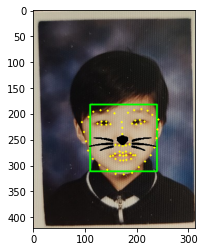

In [14]:
# 원본 이미지에 스티커 적용하기
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

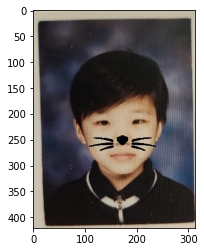

In [15]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

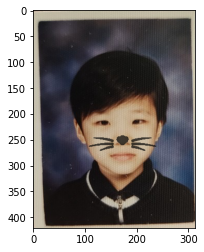

In [16]:
# 새로 불러와서 테스트하기
# cv2.addWeighted()로 img_test_a와 스티커 합성
img_test = cv2.imread(my_image_path)
img_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
img_test_alpha = img_test.copy()

sticker_area = img_test_alpha[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_test_alpha[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area, cv2.addWeighted(sticker_area, 0.3, img_sticker, 0, 0)).astype(np.uint8)
plt.imshow(img_test_alpha)
plt.show()

# 문제점 찾아보기

### 얼굴을 돌렸을 때

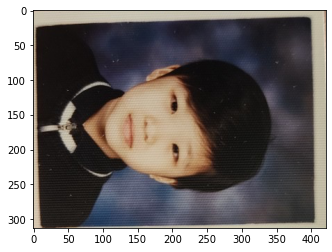

(313, 421, 3)


In [17]:
img_rotate_90 = img_test.copy()
img_rotate_90 = cv2.rotate(img_rotate_90, cv2.ROTATE_90_CLOCKWISE)

plt.imshow(img_rotate_90)
plt.show()
print(img_rotate_90.shape)

In [18]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(img_rotate_90, 1)

rectangles[]


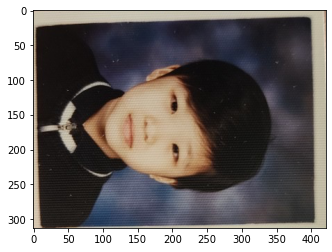

In [19]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_rotate_90, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(img_rotate_90)
plt.show()

얼굴을 90도 돌리니 검출 단계에서 인식이 되지 않았다.   

### 얼굴의 밝기를 조절했을 때
이미지를 4장 준비했다. 2장은 하얗게, 2장은 까맣게   
이미지의 색조 변화가 크고 얼굴의 이목구비가 제대로 보이지 않는데 디텍이 제대로 되는지 보고 싶어서 각각 한장씩은 극단적으로 하얗게 그리고 까맣게 준비했다.   

### 하얗게_1

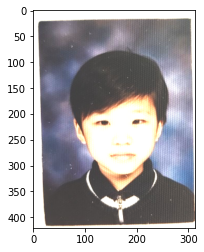

In [20]:
test_image_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/images/image1.png'
test_img_bgr = cv2.imread(test_image_path)
test_img_show = test_img_bgr.copy() # 원본은 따로 저장
test_img_test = cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(test_img_test)
plt.show()

In [21]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(test_img_test, 1)

rectangles[[(98, 167) (253, 322)]]


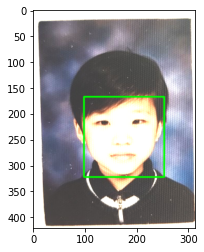

In [22]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(test_img_test, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(test_img_test)
plt.show()

### 하얗게_2

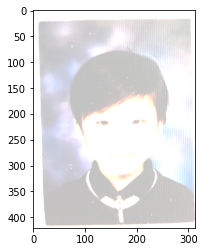

In [23]:
test_image_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/images/image2.png'
test_img_bgr = cv2.imread(test_image_path)
test_img_show = test_img_bgr.copy() # 원본은 따로 저장
test_img_test = cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(test_img_test)
plt.show()

In [24]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(test_img_test, 1)

rectangles[]


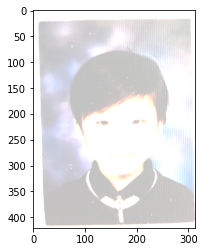

In [25]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(test_img_test, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(test_img_test)
plt.show()

### 어둡게_1

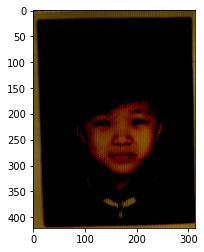

In [26]:
test_image_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/images/image3.png'
test_img_bgr = cv2.imread(test_image_path)
test_img_show = test_img_bgr.copy() # 원본은 따로 저장
test_img_test = cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(test_img_test)
plt.show()

In [27]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(test_img_test, 1)

rectangles[[(98, 167) (253, 322)]]


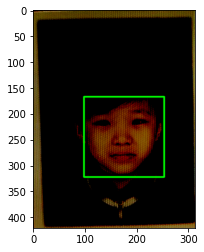

In [28]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(test_img_test, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(test_img_test)
plt.show()

### 어둡게_2

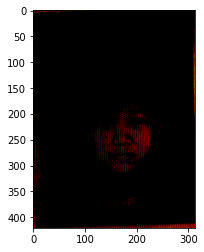

In [29]:
test_image_path = os.getenv('HOME')+'/aiffel/AI_study/face_sticker/images/image4.png'
test_img_bgr = cv2.imread(test_image_path)
test_img_show = test_img_bgr.copy() # 원본은 따로 저장
test_img_test = cv2.cvtColor(test_img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(test_img_test)
plt.show()

In [30]:
# detector 선언
detector_hog = dlib.get_frontal_face_detector()
dlib_rects = detector_hog(test_img_test, 1)

rectangles[[(77, 160) (262, 345)]]


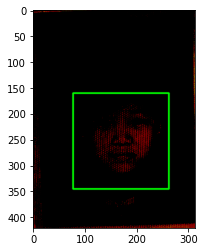

In [31]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(test_img_test, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

plt.imshow(test_img_test)
plt.show()

### 회고
정면 이목구비의 형태만 보인다면 극단적인 상황에서도 디텍터가 인식할 수 있다.   
얼굴의 끝 부분이 제대로 보이지 않는다면 디텍 사이즈에 오차가 생긴다.   
또한 눈만 인식하고 코, 입, 턱 등 윤곽이 제대로 보이지 않는다면 인식할 수 없다.   

얼굴을 90도 회전시켰을 때 detector가 인식을 못했다.   
이 말은 얼굴의 윤곽과 눈, 코, 입이 차례대로 있어야 인식할거같은데 만약 인식을 했다면 스티커를 적용할 때 랜드마크의 0번과 16번(좌, 우 관자놀이), 33번(코)과 8번(턱)의 좌표를 보고 얼굴이 얼마나 돌아가있는지 파악해서 이미지도 rotate를 하자고 생각은 했지만 detect 자체가 안되서 구현을 못해봐 아쉬웠다.   

- 얼굴이 측면에 있거나 정면의 틀에서 벗어나면 detector도 인식을 못할것이고 landmark별 포인트들도 제대로 파악이 안돼 입체화 시키지도 못한다.   
- 지금까지 했던 예제처럼 이미지를 넣고 합성해주는 프로그램이라면 괜찮겠지만 결과를 바로 보고 대응을 해야하는 사진 어플 기능이라면 실행 속도가 매우 중요하다. 프레임 별로 계산해서 바로바로 대응해줘야하기 때문이다.   
- 정확도 또한 매우 중요하다. 소비자들이 해당 기능을 소비할 때 디텍을 허공에 한다거나 얼굴에 합성을 하는데 엇나가서 이질감이 든다면 어플이 매력적이기보다 기괴하게 느껴질 것이다.